# DataBase Import 

In [1]:
import pandas as pd
data = pd.read_excel(r'./../data/Online Retail.xlsx')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France




# Data PreProcessing

In [2]:
#data preprocessing

#filering for required columns
data = data.drop(columns =['Description','Quantity','UnitPrice','CustomerID'])

#cleaning row for dropping missing values
data.dropna(axis=0,subset=['InvoiceNo','StockCode','Country'],inplace=True)

#converting columns types to str
data['InvoiceNo']= data['InvoiceNo'].astype('str')
data['StockCode']= data['StockCode'].astype('str')

#drop all the rows which are with credit in invoiceno
data = data[~data['InvoiceNo'].str.contains('C')]
data

,InvoiceNo,StockCode,InvoiceDate,Country
0,536365,85123A,2010-12-01 08:26:00,United Kingdom
1,536365,71053,2010-12-01 08:26:00,United Kingdom
2,536365,84406B,2010-12-01 08:26:00,United Kingdom
3,536365,84029G,2010-12-01 08:26:00,United Kingdom
4,536365,84029E,2010-12-01 08:26:00,United Kingdom
...,...,...,...,...
541904,581587,22613,2011-12-09 12:50:00,France
541905,581587,22899,2011-12-09 12:50:00,France
541906,581587,23254,2011-12-09 12:50:00,France
541907,581587,23255,2011-12-09 12:50:00,France


# Country Bucket

In [3]:
#country names
countries = []
countries = list(data["Country"].unique())

#country bucket
country_bucket = []
for country in countries:
	country_bucket.append(data[data["Country"] == country])

country_bucket

[       InvoiceNo StockCode         InvoiceDate         Country
 0         536365    85123A 2010-12-01 08:26:00  United Kingdom
 1         536365     71053 2010-12-01 08:26:00  United Kingdom
 2         536365    84406B 2010-12-01 08:26:00  United Kingdom
 3         536365    84029G 2010-12-01 08:26:00  United Kingdom
 4         536365    84029E 2010-12-01 08:26:00  United Kingdom
 ...          ...       ...                 ...             ...
 541889    581585     22466 2011-12-09 12:31:00  United Kingdom
 541890    581586     22061 2011-12-09 12:49:00  United Kingdom
 541891    581586     23275 2011-12-09 12:49:00  United Kingdom
 541892    581586     21217 2011-12-09 12:49:00  United Kingdom
 541893    581586     20685 2011-12-09 12:49:00  United Kingdom
 
 [487622 rows x 4 columns],
        InvoiceNo StockCode         InvoiceDate Country
 26        536370     22728 2010-12-01 08:45:00  France
 27        536370     22727 2010-12-01 08:45:00  France
 28        536370     22726 2010-1

# Class&Functions Required for Miner Function

## Item Class & MissingDefaultDict Class  

In [4]:
from collections import defaultdict,namedtuple,Counter
class missdefaultdict(defaultdict):
	def __missing__(self,key):
		if self.default_factory != None:
			return self.default_factory(key)  
		else:
			raise KeyError(key)
   
class Item():
	def __init__(self,seq,*events):
		self.events= set( )
		self.sequen = seq
		for event in events:
			self.events.add(event)

	def __eq__(self,item2):
		r= (self.sequen== item2.sequen & self.events== item2.events)
		return r
	
	def __repr__(self):
		return self.__dict__.__repr__()


	def __ior__(self,item2):
		self.events |= item2.events
		return self

## Event Tuple


In [5]:
from collections import defaultdict,namedtuple,Counter
Event = namedtuple('Event',['sid' , 'eid'])

## Relative Minsup Function

In [6]:
import math
def relative_minsup(total_invoicenos):
	
    #relative minsup is required as  value depends on size of dataset
	if total_invoicenos >10000:
		minsup = 0.03
	elif 1000 < total_invoicenos <= 10000:
		minsup = 0.05
	elif 100 < total_invoicenos <= 1000:
		minsup = 0.07
	elif 20< total_invoicenos <= 100:
		minsup = 0.2
	elif total_invoicenos <= 20:
		minsup = 0.4
	print(f'  Minsup:{minsup}')
	return math.ceil(minsup*total_invoicenos)

## SingleFrequent Function

In [7]:
def singlefrequentitems(items,support_threshold):
	
	singlefrequent = missdefaultdict(Item)

	for item_name,item in items.items():
		s = len(set([event.sid for event in item.events] ))
		
        #purning infrequent items
		if s >= support_threshold:
			singlefrequent[item_name] = item

	return singlefrequent

## 2-ItemsFrequent Identify Function 

In [8]:
def doublefrequentsequence(items,support_threshold):

	#creating a horizontal database to group all items on same sequence
	sequence_db = {}

	for item_name,item in items.items():
		for event in item.events:
			if event.sid not in sequence_db:
				sequence_db[event.sid] = []
			sequence_db[event.sid].append((item_name,event.eid))

	#counter for 2 sequence
	counter = defaultdict(int)
	for sid,sequence in sequence_db.items():
		
        #on same sequence, comparing eids to form seq_two
		for event_index_x,event_x in enumerate(sequence):
			for event_index_y,event_y in enumerate(sequence[event_index_x+1:]):
				#comparing eids
				if event_x[1] <event_y[1]:
					seq_two = tuple([event_x[0], event_y[0]])
				else:
					seq_two = tuple([event_y[0], event_x[0]])
				counter[seq_two] += 1
                
	return {tuple(sorted(seq_two)) for seq_two,counter in counter.items() if counter >= support_threshold}

## Temporal Join Function

In [9]:
def joining_temp(item_x,item_y):
	
	join_result = missdefaultdict(Item)

	for eindex_x,event_x in enumerate(item_x.events):
		for eindex_y,event_y in enumerate(item_y.events):

			#join on same sequenceId
			if event_x.sid == event_y.sid:

				sid = event_y.sid
				superseqs = tuple()
				superseqs_events = tuple()

				#for joining a sequence , the previous sequence eid must be less than the adding sequence eid
				if event_x.eid > event_y.eid:
					#add the seqeuence with less eid first and eid of supersequence has to be the larger eid
					superseq = item_y.sequen + tuple([item_x.sequen[-1]])
					superseq_event = Event(sid,event_x.eid)
					join_result[superseq] |= Item(superseq,superseq_event)

				elif event_x.eid < event_y.eid:
					superseq = item_x.sequen + tuple([item_y.sequen[-1]])
					superseq_event = Event(sid,event_y.eid)
					join_result[superseq] |= Item(superseq,superseq_event)


					#if event occur on same sequence,eid then join last item of the sequnceitem set to other
				elif item_x.sequen[-1] != item_y.sequen[-1]:
					superseq_event = Event(sid,event_y.eid)
				
					superseq_x = item_x.sequen[:-1]+tuple(
										sorted(set(
											tuple([item_x.sequen[-1]])+ tuple([item_y.sequen[-1]])
											))
										)

					join_result[superseq_x] |= Item(superseq_x,superseq_event)

					superseq_y = item_y.sequen[:-1] + tuple(
										sorted(set(
											tuple([item_x.sequen[-1]])+ tuple([item_y.sequen[-1]])
											))
										)
					
					#if both sequences are dame, add only once
					if superseq_y != superseq_x:
						join_result[superseq_y] |=Item(superseq_y,superseq_event)
	return join_result

## EnumerateFrequent Function

In [10]:
def enumerate_frequent_sequence(items,support_threshold):
	
	
	frequent_items =missdefaultdict(Item)
	seq_list=list(items.keys())
	for item_index_x,seq_x in enumerate(seq_list):
			
		frequent_items_inner=missdefaultdict(Item)

		for item_index_y,seq_y in enumerate(seq_list[item_index_x+1:]):
			join = joining_temp(items[seq_x],items[seq_y])
			
			#purning infrequent sequence
			for sequence,item in join.items():
				s = len(set([event.sid for event in item.events]))
				if s >= support_threshold:
					frequent_items_inner[sequence] |= item

		#adding inner frequent sequence to frequent list
		for sequence,item in frequent_items_inner.items():
			frequent_items[sequence] |= item
		
        #recursive call for function form n+1 sequence form n sequence
		for sequence,item in enumerate_frequent_sequence(frequent_items_inner,support_threshold).items():
			frequent_items[sequence] |= item 

	return frequent_items

# Miner Function

In [11]:
def sequential_mining(vertical_data,total_unique_invoicenos):
	
	if total_unique_invoicenos > 2:
		support_threshold = relative_minsup(total_unique_invoicenos)
	else:
		support_threshold = 2
	print(f'  Support_threshold: {support_threshold}')
	items = missdefaultdict(Item)
	
    #from vertical data lets make individual items
	for sid,eid,elements in vertical_data:
		for element in elements:
			items[tuple([element])] |= Item(tuple([element]),Event(sid,eid))
	print(f'  Total items: {len(items)}')
	
	#finding for 1-candidate frequent items
	items_len1 = singlefrequentitems(items,support_threshold)
	print(f'  Single frequent: {len(items_len1)}')
	
	#finding 2-candidate frequent items
	frequent_sequence_2 = doublefrequentsequence(items_len1,support_threshold)
	
	#creating Item class for frequent 2-items by joining the sequence 
	items_len2 = missdefaultdict(Item)
	for seq_two in frequent_sequence_2:
		#joining the seqeunce
		join_seq = joining_temp(items[seq_two[0]] , items[seq_two[1]])
		
		for seq,item in join_seq.items():
			s = len(set([event.sid for event in item.events]))
			if s>= support_threshold:
				items_len2[seq] |= item
	print(f'  Doublefrequent: {len(items_len2)}')
	
	#finding and creating Item class for all further sequences
	#enumerate frequent sequence recursivly to create n+1 sequence from n sequence
	frequent_items = enumerate_frequent_sequence(items_len2,support_threshold)

	for sequence,item in items_len1.items():
		frequent_items[sequence] |= item
	for sequence,item in items_len2.items():
		frequent_items[sequence] |= item
	return frequent_items

# Convertion to Vertical Format and call miner on country_Data

In [14]:
country_sequence_count={}
for country_data in country_bucket:
	country_name = country_data['Country'].unique()[0]
	print(f'Country: {country_name} is processing')
	unique_invoiceno = country_data['InvoiceNo'].nunique()
	country_sequence_count[country_name]=unique_invoiceno
	if unique_invoiceno == 1:
		print('  Only one Sequence present- no sufficent data')
		continue
	timegroup = country_data.groupby('InvoiceDate')
	time =1
	
    #create vertical format for a country
	vertical_data = []
	for t,t_group in timegroup:
		invoiceno_group = t_group.groupby('InvoiceNo')
		for invoiceno,group in invoiceno_group:
			invoice_items = group['StockCode'].values.tolist()
			seqrow = [invoiceno,time] + invoice_items
			vertical_data.append(tuple([seqrow[0],seqrow[1],tuple(seqrow[2:])]))
		time += 1
	
    #call mining function
	print(f'  Total_invoicenos: {unique_invoiceno}')
	frequent_items = sequential_mining(vertical_data,unique_invoiceno) 
	sequence_support={} 
	for item_name,item in frequent_items.items():
		if(len(item_name) >= 2):
			sequence_support[item_name] = len(item.events)
	if len(sequence_support) != 0:
		visualization = pd.DataFrame(sequence_support.items(),columns=['Sequence','Support Count'])
		print(visualization)
	print("-------------------------------------------------------------------------------")

Country: United Kingdom is processing
  Total_invoicenos: 20122
  Minsup:0.03
  Support_threshold: 604
  Total items: 4055
  Single frequent: 107
  Doublefrequent: 5
          Sequence  Support Count
0  (21931, 85099B)            697
1   (22697, 22699)            701
2  (22386, 85099B)            784
3   (20725, 20727)            607
4  (22411, 85099B)            657
-------------------------------------------------------------------------------
Country: France is processing
  Total_invoicenos: 392
  Minsup:0.07
  Support_threshold: 28
  Total items: 1542
  Single frequent: 43
  Doublefrequent: 41
                       Sequence  Support Count
0          (22556, 22556, POST)             41
1          (22554, 22556, POST)             33
2          (22551, 22556, POST)             29
3          (21094, 21086, POST)             32
4          (21080, 21086, POST)             33
5          (21094, 21094, POST)             41
6          (21080, 21094, POST)             33
7          (21086, 

  Total_invoicenos: 19
  Minsup:0.4
  Support_threshold: 8
  Total items: 215
  Single frequent: 0
  Doublefrequent: 0
-------------------------------------------------------------------------------
Country: Iceland is processing
  Total_invoicenos: 7
  Minsup:0.4
  Support_threshold: 3
  Total items: 103
  Single frequent: 22
  Doublefrequent: 79
                    Sequence  Support Count
0      (21731, 22726, 22727)              3
1      (22725, 22726, 22727)              3
2      (21731, 22727, 22728)              3
3      (22375, 22727, 22728)              3
4     (21731, 22727, 84558A)              3
...                      ...            ...
1799          (20719, 84991)              3
1800         (22371, 84558A)              3
1801          (21731, 22196)              3
1802          (20719, 22423)              3
1803          (22727, 22728)              3

[1804 rows x 2 columns]
-------------------------------------------------------------------------------
Country: Channel 

# PLOT

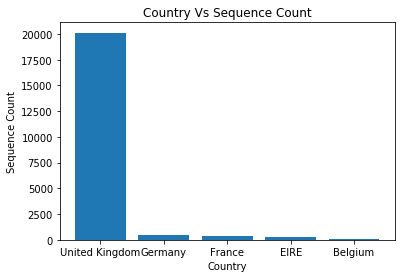

In [16]:
import matplotlib.pyplot as plt
list = sorted(country_sequence_count.items(),key=lambda x:x[1],reverse = True)[:5]
x,y = zip(*list)
plt.bar(x,y)
plt.xlabel('Country')
plt.ylabel('Sequence Count')
plt.title('Country Vs Sequence Count')
plt.savefig('./../plot/Country vs Sequence Count')

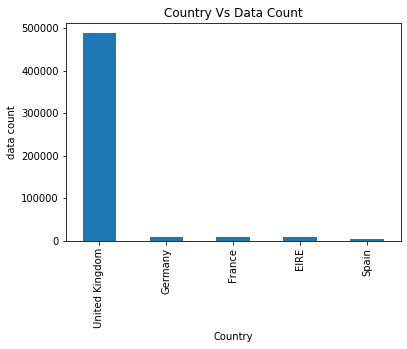

In [17]:
import matplotlib.pyplot as plt
data['Country'].value_counts()[:5].plot(kind='bar')
plt.ylabel('data count')
plt.xlabel('Country')
plt.title( 'Country Vs Data Count') 
plt.savefig('./../plot/Country vs DataCount')